# Building a Convolutional Neural Network (CNN)

**CNN that replicates the model on the [CNN Explainer website.](https://poloclub.github.io/cnn-explainer/)**

In [1]:
# import pytorch
import torch
from torch import nn

#import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

#import matplotlib for visualization
import matplotlib.pyplot as plt

# Import tqdm for progress bar
from tqdm.auto import tqdm

# Prepare Dataset

In [2]:
# training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get all the training data
    download=True, # download the data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors 
    target_transform=None # you can transform labels as well
)

# testing data
test_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=False, # get all the training data
    download=True, # download the data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors 
    target_transform=None # you can transform labels as well
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
class_names = train_data.classes
print(class_names)
class_names_dict = train_data.class_to_idx
print(class_names_dict)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


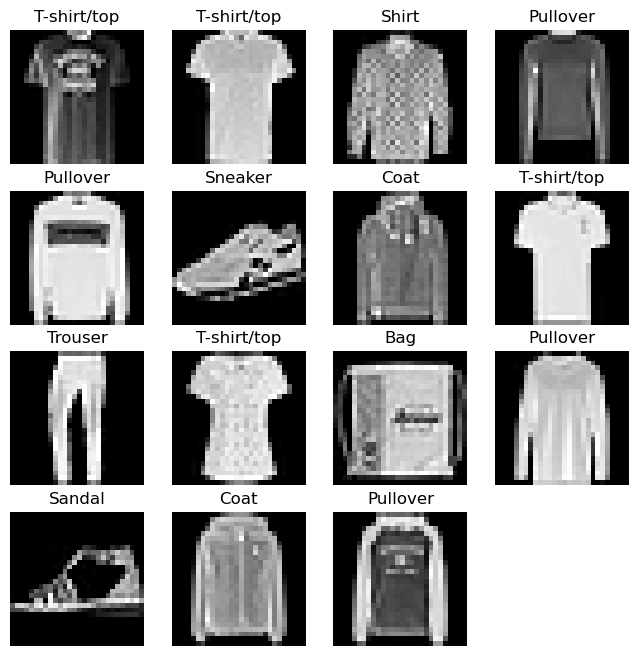

In [6]:
#torch.manual_seed(42)
figure_size = plt.figure(figsize=(8,8))
row,column=4,4
for i in range(1,row*column):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    image, label = train_data[random_idx]
    figure_size.add_subplot(row,column,i)
    plt.imshow(image.squeeze(),cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width) and in the gray scale image we have to remove extra 
                            # one dimention by squeeze() method
    plt.title(class_names[label])
    plt.axis(False)
plt.show()

In [26]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE, 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [8]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Build model

In [27]:
# Create a convolutional neural network 
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2) # default stride value is same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
 
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(f"Output shape of Conv2d_1 is: {x.shape}")
        x = self.block_2(x)
        #print(f"Output shape of Conv2d_2 is: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape of classifier is: {x.shape}")
        return x
    


In [28]:
 # Need to setup model with input parameters  
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_2.to(device)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

# Setup a loss function and optimizer for model_2

In [29]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [30]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
# Import accuracy metric
from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download


In [31]:
### For timing calculation 
from timeit import default_timer as timer  # used to get the code running time
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

# Training and testing model_2 using our training and test functions

In [32]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [33]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start = timer()

epochs = 10
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end = timer()
total_train_time_model_2 = print_train_time(start=train_time_start,
                                            end=train_time_end,
                                            device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59649 | Train accuracy: 78.39%
Test loss: 0.39203 | Test accuracy: 85.79%

Epoch: 1
---------
Train loss: 0.36010 | Train accuracy: 87.06%
Test loss: 0.36059 | Test accuracy: 86.53%

Epoch: 2
---------
Train loss: 0.32377 | Train accuracy: 88.23%
Test loss: 0.32374 | Test accuracy: 88.11%

Epoch: 3
---------
Train loss: 0.30392 | Train accuracy: 88.97%
Test loss: 0.32474 | Test accuracy: 88.06%

Epoch: 4
---------
Train loss: 0.28955 | Train accuracy: 89.48%
Test loss: 0.30551 | Test accuracy: 88.79%

Epoch: 5
---------
Train loss: 0.27805 | Train accuracy: 89.90%
Test loss: 0.30752 | Test accuracy: 88.92%

Epoch: 6
---------
Train loss: 0.26802 | Train accuracy: 90.31%
Test loss: 0.31616 | Test accuracy: 88.79%

Epoch: 7
---------
Train loss: 0.26377 | Train accuracy: 90.53%
Test loss: 0.28717 | Test accuracy: 89.47%

Epoch: 8
---------
Train loss: 0.25850 | Train accuracy: 90.61%
Test loss: 0.30408 | Test accuracy: 89.37%

Epoch: 9
---------
Train los

In [34]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X,y = X.to(device),y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            #print((y_pred.argmax(dim=1)).shape)
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 2 results on test dataset
model_2_results = eval_model(model=model_2, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3051741123199463,
 'model_acc': 89.20726837060703}

# Making and evaluating predictions

In [35]:
test_dataloader = DataLoader(test_data,
    batch_size=1,
    shuffle=False # don't necessarily have to shuffle the testing data
)
test_sample = []
test_labels = []
test_pred_labels = []
counter = 0
model_2.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        counter+=1
        X,y = X.to(device),y.to(device)
        y_pred = model_2(X)
        y_logits =y_pred.argmax(dim=1)
        test_labels+=list(y.cpu().numpy())
        test_pred_labels+=list(y_logits.cpu().numpy())
        test_sample+=list(X.cpu())
        if counter==9:
            break
import pandas as pd
label_df = pd.DataFrame({'test_labels':test_labels,'test_pred_labels':test_pred_labels})
label_df

,test_labels,test_pred_labels
0,9,9
1,2,2
2,1,1
3,1,1
4,6,6
5,1,1
6,4,4
7,6,6
8,5,5


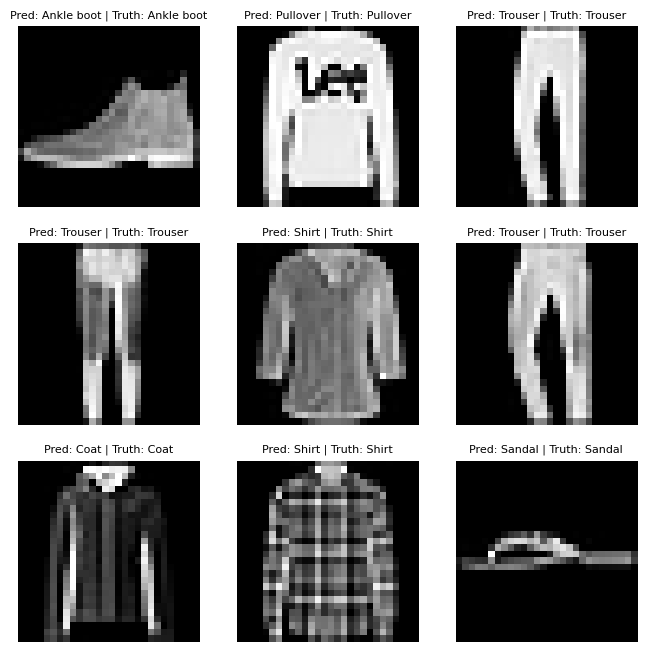

In [36]:
#torch.manual_seed(42)
figure_size = plt.figure(figsize=(8,8))
row,column=3,3
for i in range(0,row*column):
    image = test_sample[i]
    figure_size.add_subplot(row,column,i+1)
    plt.imshow(image.squeeze(),cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width) and in the gray scale image we have to remove extra 
                            # one dimention by squeeze() method
    title_text = f"Pred: {class_names[test_pred_labels[i]]} | Truth: {class_names[test_labels[i]]}"
    plt.title(title_text,fontsize=8)
    plt.axis(False)
plt.show()

In [37]:
### Make prediction on whole test dataset


test_dataloader_for_pred = DataLoader(test_data,
    batch_size=1,
    shuffle=False # don't necessarily have to shuffle the testing data
)
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X, y in test_dataloader_for_pred:
        X,y = X.to(device),y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())
#import pandas as pd
#label_df = pd.DataFrame({'test_labels':test_labels,'test_pred_labels':test_pred_labels})
#label_df

In [38]:
print(y_preds[:10])

[tensor([9]), tensor([2]), tensor([1]), tensor([1]), tensor([6]), tensor([1]), tensor([4]), tensor([6]), tensor([5]), tensor([7])]


In [39]:
y_preds_tensor  = torch.cat(y_preds)

In [40]:
print(y_preds_tensor[:10])

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])


In [41]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

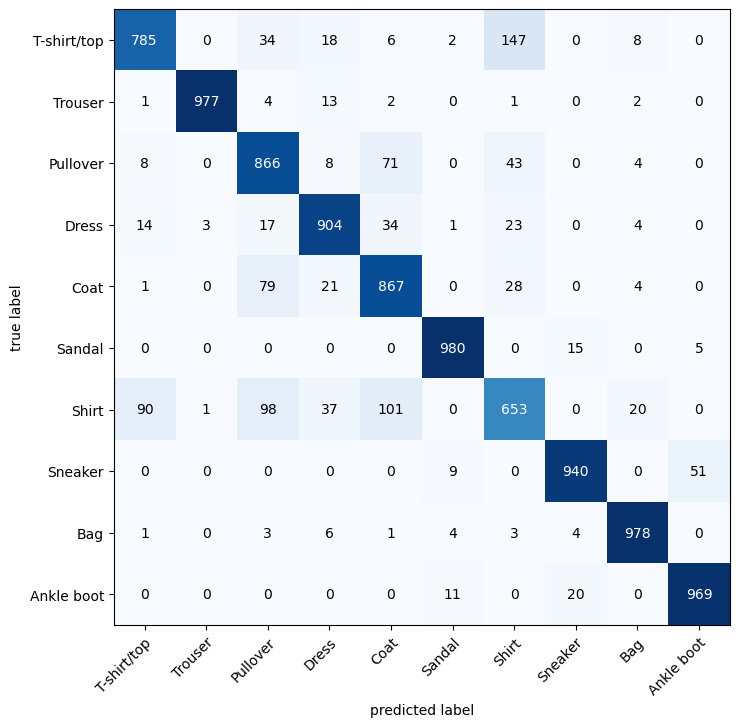

In [42]:
# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_preds_tensor, target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10, 8));

# Save and Load the model

In [43]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "05_Pytorch_CNN_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/05_Pytorch_CNN_model_2.pth


In [44]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)
loaded_model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [46]:
# Calculate model 2 results on test dataset
loaded_model_2_results = eval_model(model=loaded_model_2, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.305451899766922,
 'model_acc': 89.19}